<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [1]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!pip install pip install better-profanity --quiet
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers==4.5.1 --quiet
!pip install wandb --quiet
!pip install onnxruntime --quiet
# !python -m spacy download en_core_web_md --quiet

     |████████████████████████████████| 153kB 14.2MB/s 
     |████████████████████████████████| 1.8MB 26.7MB/s 
     |████████████████████████████████| 3.8MB 58.8MB/s 
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 225kB 14.6MB/s 
     |████████████████████████████████| 245kB 20.8MB/s 
     |████████████████████████████████| 112kB 27.6MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 849kB 15.7MB/s 
     |████████████████████████████████| 829kB 58.5MB/s 
     |████████████████████████████████| 276kB 56.2MB/s 
     |████████████████████████████████| 276kB 60.0MB/s 
     |████████████████████████████████| 6.0MB 48.5MB/s 
     |████████████████████████████████| 1.3MB 54.2MB/s 
     |████████████████████████████████|

In [32]:
import pandas as pd
import numpy as np
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from better_profanity import profanity
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.apply.dask import DaskLFApplier
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher
import numpy as np
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import PhraseMatcher

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, BackboneFinetuning, QuantizationAwareTraining, ModelPruning
from pytorch_lightning.loggers import TensorBoardLogger
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

# weights and biases
import wandb

# lightning plus wandb
from pytorch_lightning.loggers import WandbLogger

# Saving and running model with ONNX
import onnxruntime

wandb.login()

Global seed set to 42


True

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 261MB/s]


We can take a look at the data:

In [4]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'labels' because Snorkel prefers this.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

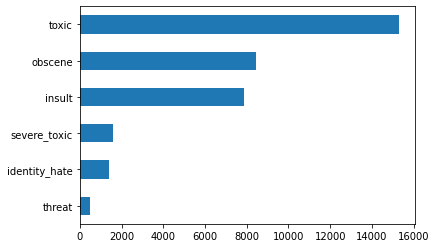

In [5]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Now, let's add them all up together and compare them to the number of clean comments.

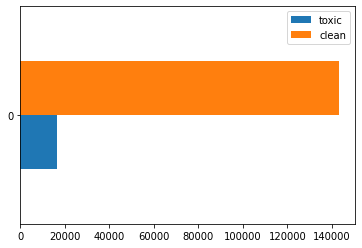

In [6]:
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(df_toxic)], 
  clean=[len(df_clean)]
)).plot(kind='barh');

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced. We will simply reduce the number of clean comments to a number that is comparable to the toxic comments.

In [7]:
train_df = pd.concat([
  df_toxic.sample(2000, random_state=42),
  df_clean.sample(2000, random_state=42)
])

print(len(train_df))
train_df.head()

3000


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1,0,0,0,0,0
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1,1,1,0,1,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1,0,1,0,1,0
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1,0,0,0,0,0
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1,0,1,0,1,0


### Merging All Toxic Comments Together

In [8]:
train_df['label'] = np.where(train_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
88045,eb8cefa54813f3bc,Thanks and bye\nJust wanted to thank you for m...,0,0,0,0,0,0,0
44474,76c473f8898626ce,"Seems to be at it again, in force",0,0,0,0,0,0,0
75044,c8cc3dca0745ba2f,Still meaningless. It's a random example of Wi...,0,0,0,0,0,0,0
103363,29236fd9f0ccd41e,I don't know. Is it a good idea to delete art...,0,0,0,0,0,0,0
130762,bb846cf699d149a4,"""\n\nActually, the NY Times made much the same...",0,0,0,0,0,0,0


In [9]:
train_df = train_df.drop(LABEL_COLUMNS, axis=1)
train_df

,id,comment_text,label
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1
...,...,...,...
88045,eb8cefa54813f3bc,Thanks and bye\nJust wanted to thank you for m...,0
44474,76c473f8898626ce,"Seems to be at it again, in force",0
75044,c8cc3dca0745ba2f,Still meaningless. It's a random example of Wi...,0
103363,29236fd9f0ccd41e,I don't know. Is it a good idea to delete art...,0


## Preparing the Data for Snorkel

In [10]:
train_df = train_df.rename(columns={"comment_text": "text"})
train_df.head()

,id,text,label
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1


Here we create 4 dataset splits. We are emulating the situation where we have a small labeled dataset where we can use for model training, and then mesure our Labeling Function accuracy. What we call `fine_tune_df` (Fine-Tune Set), `val_df` (Validation Set), and `test_df` (Test Set) contain labeled data. The `train_df` is the unlabeled dataset we will be using Snorkel to label.

*   `fine_tune_df`: Labeled data we use for fine-tuning the bert model before putting model into a Snorkel Labeling Function.
*   `val_df`: This is our small dataset split we will use to measure the performance of the bert model trained with `fine_tune_df`.
*    `train_df`: As mentioned, the `train_df` is the unlabeled dataset we will be using Snorkel to label.
*    `test_df`: This is our dataset split for testing Snorkel's Label Model to get an estimate on how many labels were correctly labeled in our `train_df`.

In [11]:
fine_tune_df = train_df.groupby('label').apply(lambda s: s.sample(500, random_state=123)).reset_index(level=0, drop=True)
train_df.drop(fine_tune_df.index, inplace=True)

train_df, test_df = train_test_split(train_df, test_size=0.25)
val_df = test_df.sample(frac=0.1)
test_df.drop(val_df.index, inplace=True)

print('Train:', len(train_df), '\t Fine-Tune Set:', len(fine_tune_df), '\t Test:', len(test_df), '\t', 'Valid:', len(val_df))

Train: 1800 	 Dev: 600 	 Test: 540 	 Valid: 60


In [12]:
train_df.to_csv('toxic_train_1800_examples.csv')
test_df.to_csv('toxic_test_540_examples.csv')
val_df.to_csv('toxic_val_60_examples.csv')
fine_tune_df.to_csv('toxic_fine_tune_600_examples.csv')

In [13]:
train_df.drop(['label'], axis=1, inplace=True)

## Creating BERT sentiment model for labeling

In [27]:
BERT_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
# BERT_MODEL_NAME = "bert-base-cased"

In [160]:
model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [161]:
MAX_TOKEN_COUNT = 512

In [162]:
sample_comment = "The problem with saying that Warren G. Harding was the first African-American President is that it"

In [163]:
data_row = fine_tune_df.iloc[19]

sample_text = data_row.text
labels = data_row['label']

print(sample_text)
print()
print(labels)

Important people of the battle 

Brack Obama
Santa Clause
Easter Bunny
Leprechaun
Ron Gerardis
Cupid
Ronald Mcdonald
Tooth Fairy

0


In [164]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [165]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'important', 'people', 'of', 'the', 'battle', 'bra', '##ck', 'obama', 'santa', 'clause', 'easter', 'bunny', 'le', '##pre', '##chau', '##n', 'ron', 'gerard', '##is']


In [166]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [167]:
torch.cuda.empty_cache()

In [168]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row['label']

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=labels
    )

In [169]:
train_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [170]:
sample_item["comment_text"]

'I take it your an admin. What are you going to do about this guys racist edits. He has me pissed. I looked at his contributions they are all negative and he is trying to portray a bad image of Mid-Eastern people. I even saw racist comments.'

In [171]:
sample_item["labels"]

1

In [172]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [173]:
output = model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [174]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [175]:
model.config.hidden_size

768

In [176]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=4, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

In [177]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  fine_tune_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [198]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, num_classes: int, input_dims=(8, 512), attention_mask=(8, 512), n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.backbone = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()

    # log hyperparameters
    self.save_hyperparameters()

    # compute the accuracy -- no need to roll your own!
    self.train_acc = pl.metrics.Accuracy()
    self.val_acc = pl.metrics.Accuracy()
    self.test_acc = pl.metrics.Accuracy()
    self.train_f1 = pl.metrics.F1(num_classes=num_classes)
    self.val_f1 = pl.metrics.F1(num_classes=num_classes)
    self.test_f1 = pl.metrics.F1(num_classes=num_classes)

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.backbone(input_ids, attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels) # calls self.forward
    preds = torch.argmax(outputs, 1) # take the highest predicted number

    self.test_acc(preds, labels)
    self.test_f1(preds, labels)
    self.log('test/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('test/acc_epoch', self.test_acc, on_step=False, on_epoch=True)
    self.log('test/f1_epoch', self.test_f1, on_step=False, on_epoch=True)

    # self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": preds, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    preds = torch.argmax(outputs, 1)

    self.val_acc(preds, labels)
    self.val_f1(preds, labels)
    self.log('val/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('val/acc_epoch', self.val_acc, on_step=False, on_epoch=True)
    self.log('val/f1_epoch', self.val_f1, on_step=False, on_epoch=True)

    # self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_epoch_end(self, validation_step_outputs):

    # Saving our model weights and biases every epoch.
    # This way, if we overfit, we can just roll back our weights to the saved weights at the best epoch
    dummy_input = torch.zeros((self.hparams['input_dims'], self.hparams['attention_mask']), device=self.device)
    model_filename = f'model_{str(self.global_step).zfill(5)}.onnx'
    torch.onnx.export(self, dummy_input, model_filename)
    wandb.save(model_filename)

    # flatten validation step outputs as a pytorch tensor and turn into a histogram
    flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
    self.logger.experiment.log(
        {'valid/logits': wandb.Histogram(flattened_logits.to('cpu')),
          'global_step': self.global_step}
    )

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    preds = torch.argmax(outputs, 1)

    self.test_acc(preds, labels)
    self.test_f1(preds, labels)
    self.log('test/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('test/acc_epoch', self.test_acc, on_step=False, on_epoch=True)
    self.log('test/f1_epoch', self.test_f1, on_step=False, on_epoch=True)

    # self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [199]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [200]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(300, 1500)

In [201]:
model = ToxicCommentTagger(
  num_classes=2,
  input_dims=(8, 512),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [202]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val/loss_epoch",
  mode="min"
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


#### Callbacks

In [203]:
early_stopping_callback = EarlyStopping(monitor='val/loss_epoch', patience=2)

In [204]:
multiplicative=lambda epoch: 1.5 # modifies learning rate after unfreeze
backbone_finetuning = BackboneFinetuning(5, multiplicative) # freezes pretrained model until 5 epochs

In [33]:
model_pruning = ModelPruning(
        pruning_fn='l1_unstructured',
        amount=0.1,
        use_global_unstructured=True,
    )

In [34]:
quantization_aware_training = QuantizationAwareTraining()

#### Wandb Logging

In [239]:
%env WANDB_LOG_MODEL=true
wandb.init(project="weak-supervision-fsdl-project", entity="weak-supervision-classifier-team")

env: WANDB_LOG_MODEL=true


In [206]:
wandb_logger = WandbLogger(project="weak-supervision-fsdl-project", entity="weak-supervision-classifier-team")

## Create PyTorch Lightning Trainer and Fit Model

In [207]:
trainer = pl.Trainer(
  logger=wandb_logger,
  log_every_n_steps=50,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback, backbone_finetuning, model_pruning, quantization_aware_training],
  max_epochs=N_EPOCHS,
  gpus=1,
  deterministic=True,
  progress_bar_refresh_rate=30,
  precision=16
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [208]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | BertModel        | 167 M 
1 | classifier | Linear           | 1.5 K 
2 | criterion  | CrossEntropyLoss | 0     
3 | train_acc  | Accuracy         | 0     
4 | val_acc    | Accuracy         | 0     
5 | test_acc   | Accuracy         | 0     
6 | train_f1   | F1               | 0     
7 | val_f1     | F1               | 0     
8 | test_f1    | F1               | 0     
------------------------------------------------
1.5 K     Trainable params
167 M     Non-trainable params
167 M     Total params
669.432   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric F1 was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0, global step 49: val/loss_epoch reached 0.68149 (best 0.68149), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Epoch 1, global step 99: val/loss_epoch reached 0.67986 (best 0.67986), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Epoch 2, global step 149: val/loss_epoch reached 0.67702 (best 0.67702), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Epoch 3, global step 199: val/loss_epoch reached 0.67343 (best 0.67343), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Epoch 4, global step 249: val/loss_epoch reached 0.66866 (best 0.66866), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'transformers.optimization.AdamW'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  warnings.warn(*args, **kwargs)


Epoch 5, global step 299: val/loss_epoch reached 0.41211 (best 0.41211), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Epoch 6, global step 349: val/loss_epoch reached 0.40516 (best 0.40516), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Epoch 7, step 399: val/loss_epoch was not in top 1


Epoch 8, step 449: val/loss_epoch was not in top 1


1

In [209]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc_epoch': 0.949999988079071,
 'test/f1_epoch': 0.949999988079071,
 'test/loss_epoch': 0.4051564335823059}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric F1 was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


[{'test/acc_epoch': 0.949999988079071,
  'test/f1_epoch': 0.949999988079071,
  'test/loss_epoch': 0.4051564335823059}]

In [241]:
wandb.finish()

## Loading the Trained Model on a Testing it on a Comment

In [211]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=2
)
trained_model.eval()
trained_model.freeze()

In [224]:
test_comment = "you're so cool"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(['non-toxic', 'toxic'], test_prediction):
  print(f"{label}: {prediction}")

non-toxic: 0.8567990064620972
toxic: 0.13947176933288574


In [225]:
test_prediction[1]

0.13947177

## Saving the Trained Model in ONNX Format

We did this with wandb, during training, but we'll do it locally as well.

In [ ]:
model_filepath = 'fine_tuned_bert.onnx'
trained_model.to_onnx(model_filepath, encoding["input_ids"], encoding["attention_mask"], export_params=True)

Once you have the exported model, you can run it on your ONNX runtime in the following way:

In [ ]:
ort_session = onnxruntime.InferenceSession(model_filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: (np.random.randn(8, 512).astype(np.float32), np.random.randn(8, 512).astype(np.float32))}
ort_outs = ort_session.run(None, ort_inputs)

## Writing Labeling Functions (LFs)

For clarity, we define constants to represent the class labels for non-toxic, toxic, and abstaining. These will go into our labeling functions so that the constants feed into the labeling process.

In [14]:
ABSTAIN = -1
NONTOXIC = 0
TOXIC = 1

In [15]:
# Useful for looking at the data and creating the labeling functions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

Let's at a sample of the dataset so that we can come up with labeling functions.

In [16]:
fine_tune_df

,id,text,label
75562,ca209ba9f5e6c427,"""\n\nQuoting it in full:\n\n A7. No indication of importance (individuals, animals, organizations, web content).\n An article about a real person, individual animal(s), organization (e.g. band, club, company, etc., except schools),Past discussions leading to schools being exempt from A7. or web content that does not indicate why its subject is important or significant. This is distinct from verifiability and reliability of sources, and is a lower standard than notability. This criterion applies only to articles about web content and to articles about people, organizations, and individual animals themselves, not to articles about their books, albums, software, or other creative works. This criterion does not apply to species of animals, only to individual animal(s). The criterion does not apply to any article that makes any credible claim of significance or importance even if the claim is not supported by a reliable source or does not qualify on Wikipedia's notability guidelines.It is irrelevant whether the claim of notability within the article falls below the notability guidelines. If the claim is credible, the A7 tag can not be applied. The criterion does apply if the claim of significance or importance given is not credible. If the claim's credibility is unclear, you can improve the article yourself, propose deletion, or list the article at articles for deletion.\n , – for people, – for bands, – for clubs, societies, groups, and organizations, – for companies and corporations, – for websites, – for individual animals\n\nPlease note the bolded text.""",0
132186,c35ee1f2038ebd08,"File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg\nHi. If you'd be able to track down the source description page and info for File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg which you uploaded here a while back and is now on Commons, that would be great, thanks! Thanks for your work. Cheers,",0
3704,09e68df5ff03c01f,"message from you regarding THREATS, STALKING, HARASSMENT, VIOLATION OF TERMS OF SERVICE AND CYBER BULLING FROM USER KERI.\n\nUser Keri has engaged in a pattern of threat, harassment, stalking and cyberbullying against me despite my telling them never to contact me again.\nNext I got an implicit threat from you alleging a legal threat involving me. The conduct that user KERI is involved in are all illegal and I have repeatedly demanded that user stop contacting me. Stop using your position of authority to takes sides with the mods and admins against the 99% by censoring us and trying to intimidate us.",0
42542,718a3018dc34e106,"I'll give you the benefit of the doubt as an experienced editor; however, in my personal opinion, we do not need a redirect to every article title from every conceivable grammatical variant of the title which might theoretically be used in a sentence. That's what piped links are for. (call me Russ)",0
110576,4f8eeca4ccf6d666,"Communists Appearing on Iranian TV + Are They Having A Laugh? \n\nThat is the question. History students will know that Communists inspired the Iranian Revolution in 1979 and did the heavy lifting. They were then butchered by the Ayatollah and his followers. So, what kind of a Leftie would make an appearance on Press TV, which is run by the same Govt? Some kind of a Useful Idiot, that's who!",0
...,...,...,...
43595,74629fbb1f3097b7,"Kuratowski's Ghost -> TROLL \nWatch out. Kuratowski's Ghost is a reference-hating troll. Several times now he's tried to erase facts. Sorry. You suck, troll. No win for you.",1
144678,10c5d97232cc7a30,"""\n\n Well a new section, I hope you read this \n\nI cursed at you previously, and it was deleted. To be honest; if I was face to face with you; I would have cursed at your mother. Your stupid fund raising mentality, and your inexistance at wikipedia doesn't represent your existance. \n\nIn my humble opinition; you're an idiot. Not only an idiot, you're a dumb and stupid one for this whole wikipedia socie

In [17]:
# Showing the most common words to make the labeling function creation process quicker
# This is where we can come up with a custom keyword list

pd.Series(' '.join(fine_tune_df[fine_tune_df['label'] == 1].sample(100, random_state=42).text).split()).value_counts()[:100]

is           224
all          179
Bollocks     162
bollocks     161
you          139
to           131
a            120
the          119
and           99
I             85
of            64
your          60
that          57
on            42
are           40
in            34
my            34
for           33
be            32
with          31
it            31
You           29
have          26
don't         23
"             23
me            22
about         21
fucking       21
not           21
this          20
know          20
as            17
so            17
like          15
or            15
what          15
article       14
you're        14
do            14
they          13
people        13
who           13
off           12
but           12
If            12
by            12
from          12
will          12
an            12
YOU           12
was           11
his           11
nothing       11
fuck          10
i             10
if            10
would         10
any           10
own           

## Labeling Functions

In [20]:
@nlp_labeling_function()
def contains_work_of_art(x):
    """If comment contains titles of books, songs, etc., label non-toxic, else abstain"""
    if any([ent.label_ == "WORK_OF_ART" for ent in x.doc.ents]):
        return NONTOXIC
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def contains_entity(x):
    """If comment contains least 3 mentions of an entity, label non-toxic, else abstain"""
    if len([ent.label_ in ["PERSON", "GPE", "LOC", "ORG", "LAW", "LANGUAGE"] for ent in x.doc.ents])>2:
        return NONTOXIC
    else:
        return ABSTAIN

In [21]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    """If comment has a polarity score between +0.9 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    """If comment has a subjectivity score between +0.7 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.subjectivity >= 0.7 else ABSTAIN

In [22]:
# @labeling_function()
# def contains_profanity(x):
#     """
#     If comment contains profanity label toxic, else abstain. 
#     Profanity determined using this library - https://github.com/snguyenthanh/better_profanity
#     """
#     return TOXIC if profanity.contains_profanity(x.text) else ABSTAIN

In [23]:
# @nlp_labeling_function()
# def contains_pleaseread(x):
#     """
#     Will match commonly occuring phrases like - 
#     Please read this
#     Please read the
#     Please read
#     """
#     matcher = PhraseMatcher(nlp.vocab)
#     pattern = [{"LEMMA": "please"},
#                {"LEMMA": "read"},
#                {"LEMMA": "the", "OP": "?"},
#                {"LEMMA": "this", "OP": "?"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_stopvandalizing(x):
    """
    Will match commonly occuring phrases like - 
    stop vandalizing
    do not vandalize
    don't vandalize
    """
    matcher = Matcher(nlp.vocab)
    pattern1 = [{"LEMMA": "do"},
                {"LEMMA": "not"},
                {"LEMMA": "vandalize"}]
    pattern2 = [{"LEMMA": "stop"}, 
                {"LEMMA": "vandalize"}]
    matcher.add("p1", None, pattern1)
    matcher.add("p2", None, pattern2)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
# @nlp_labeling_function()
# def contains_harassme(x):
#     """
#     Will match commonly occuring phrases like - 
#     harass me
#     harassed me
#     harassing me
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LOWER": "harass"}, 
#                {"LOWER": "me"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

# @nlp_labeling_function()
# def contains_willreport(x):
#     """Will match commonly observed phrases like - 
#     report you
#     reported you
#     reporting you
#     reported your
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LEMMA": "report"}, 
#                {"LEMMA": "you"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

In [24]:
@nlp_labeling_function()
def contains_email(x):
    """If comment contains email address, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_EMAIL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_url(x):
    """If comment contains url, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_URL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [25]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=TOXIC):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# need to load badwords.txt in directory if you decide to run commented code below

# with open('badwords.txt') as f:
#     toxic_stopwords = f.readlines()

# toxic_stopwords = [x.strip() for x in toxic_stopwords] # len = 458
# """Comments mentioning at least one of Google's Toxic Stopwords 
# https://code.google.com/archive/p/badwordslist/downloads are likely toxic"""
# keyword_toxic_stopwords = make_keyword_lf(keywords=toxic_stopwords)

keyword_please = make_keyword_lf(keywords=["please", "plz", "pls", "pl", "Please read this", "Please read the", "Please read"], label=NONTOXIC)

keyword_thanks = make_keyword_lf(keywords=["thanks", "thank you", "thx", "tx"], label=NONTOXIC)

In [26]:
# @labeling_function()
# def capslock(x):
#     """If comment is written in all caps, label toxic, else abstain"""
#     return TOXIC if x.text == x.text.upper() else ABSTAIN

In [226]:
@labeling_function()
def lf_bert_sentiment(x):
    """ Hatespeech may have a negative sentiment.
        
    Ranks the text given a sentiment from a pretrained bert transformer for movie reviews sentiment analysis.
    Note: For larger datasets, we should compute this in batches and ahead-of-time.
    """

    try:
      
      encoding = tokenizer.encode_plus(
      x.text,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

      _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
      toxic_proba = test_prediction.flatten().numpy()[1]

      if toxic_proba >= 0.7:
          return TOXIC
      if toxic_proba >= 0.3: 
          return NONTOXIC
      return ABSTAIN

    except:
      return ABSTAIN

In [227]:
lfs = [
      contains_work_of_art,
      contains_entity,
      # textblob_polarity,          # Removed: only labeled 2 examples with 50% accuracy
      # textblob_subjectivity,    # Removed: 35% accuracy
      # contains_profanity,       # Removed: 62% accuracy, removed to make labeling faster
      # contains_pleaseread,
      # contains_stopvandalizing,
      # contains_harassme,        # Removed: 50% on 4 examples
      # contains_willreport,      # Removed: labels 1 example and gets it wrong
      contains_email,
      contains_url,
      # keyword_toxic_stopwords,  # Removed: 22% accuracy
      keyword_please,
      keyword_thanks,
      # capslock                  # Removed: 55% accuracy, doesn't label many examples
      lf_bert_sentiment
]

## Applying the Labeling Functions

In [228]:
applier = DaskLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1800/1800 [26:54<00:00,  1.11it/s]


In [229]:
L_test = applier.apply(df=test_df)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 540/540 [07:49<00:00,  1.15it/s]


## Saving `L_train`

In [230]:
import pickle

with open('L_train_toxic_finetuned_bert_600ex_1.pkl','wb') as f:
  pickle.dump(L_train, f)
with open('L_train_toxic_finetuned_bert_600ex_1.pkl','rb') as f:
  L_train = pickle.load(f)
  print(L_train.shape)

(1800, 7)


In [231]:
L_train

array([[-1, -1, -1, ...,  0, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ...,  0, -1,  1],
       ...,
       [-1, -1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ...,  0, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1]])

## Testing our Label Model

In [232]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
contains_work_of_art,0,[0],0.057778,0.055556,0.017222
contains_entity,1,[0],0.296667,0.241667,0.111111
contains_email,2,[0],0.001667,0.001667,0.000556
contains_url,3,[0],0.027778,0.021667,0.007222
keyword_please,4,[0],0.316111,0.240000,0.112778
keyword_thanks,5,[0],0.081111,0.061111,0.013333
lf_bert_sentiment,6,"[0, 1]",0.507222,0.195000,0.185556


In [233]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [234]:
Y_test = test_df.label.values
LFAnalysis(L_test, lfs).lf_summary(Y_test)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
contains_work_of_art,0,[0],0.066667,0.062963,0.025926,25,11,0.694444
contains_entity,1,[0],0.274074,0.227778,0.133333,85,63,0.574324
contains_email,2,[],0.000000,0.000000,0.000000,0,0,0.000000
contains_url,3,[0],0.018519,0.014815,0.009259,6,4,0.600000
keyword_please,4,[0],0.287037,0.218519,0.116667,98,57,0.632258
keyword_thanks,5,[0],0.092593,0.064815,0.018519,42,8,0.840000
lf_bert_sentiment,6,"[0, 1]",0.553704,0.200000,0.196296,259,40,0.866221


## Downloading Files from Colab

In [235]:
from google.colab import files
files.download('L_train_toxic_finetuned_bert_600ex_1.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [236]:
trainer.save_checkpoint("finetuned_bert_600ex_1.ckpt")

In [237]:
files.download('finetuned_bert_600ex_1.ckpt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [240]:
wandb.save('*ckpt*')

wandb: WARNING Symlinked 1 file into the W&B run directory, call wandb.save again to sync new files.


['/content/wandb/run-20210512_052017-hoyw7fdx/files/finetuned_bert_600ex_1.ckpt']

## Training Deep Learning Model on New Data Obtained with Snorkel!

In [403]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer(preserve_case=False)
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 3))

In [404]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

In [405]:
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
snorkel_label_probs = label_model.predict_proba(L=L_train)
X, y = filter_unlabeled_dataframe(X=train_df.text, y=snorkel_label_probs, L=L_train)
X = vectorizer.fit_transform(X)
classifier.fit(X, probs_to_preds(probs=y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [433]:
X = vectorizer.transform(fine_tune_df.text.tolist())
y_true = fine_tune_df.label.values    
y_pred = classifier.predict(X)

In [434]:
pd.DataFrame(y_pred).sum()

0    64
dtype: int64

In [435]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       100
           1       0.84      0.54      0.66       100

    accuracy                           0.72       200
   macro avg       0.75      0.72      0.71       200
weighted avg       0.75      0.72      0.71       200

